In [7]:
!pip install pubchempy
!pip install rdkit
!pip install chemspipy
!pip install chembl_webresource_client
!pip install cirpy

In [59]:
import pandas as pd
import numpy as np
import pubchempy as pbp
import requests
from rdkit import Chem
from chembl_webresource_client.new_client import new_client
import chemspipy
import subprocess
import cirpy
import random

In [26]:
df = pd.read_csv('6.csv')

In [27]:
df

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
0,10.1016/S0022-3093(99)00330-0,7/19/1999,Journal of Non-Crystalline Solids,PHOTOINDUCEDCHANGESINLINEARNONLINEAROPTICALPRO...,As20S60Ge20,0.0,NaN,el_cde_tables,"[['As', 20.0], ['Ge', 20.0], ['S', 60.0]]",2.054,n
1,10.1016/j.fct.2006.05.017,6/7/2006,Food and Chemical Toxicology,GENERATIONFORMALDEHYDEINCIGARETTESOVERVIEWRECE...,Propionaldehyde,0.0,NaN,el_cde_tables,CCC=O,3.74,n
2,10.1016/j.mee.2011.01.031,1/18/2011,Microelectronic Engineering,SINUSOIDALPLASMONICCRYSTALSFORBIODETECTIONSENSORS,PEO,0.0,NaN,el_cde_text,"[['O', 1.0], ['PE', 1.0]]",1.47,refractive index
3,10.1016/j.apradiso.2012.04.026,5/2/2012,Applied Radiation and Isotopes,BENCHMARKINGGEANT4FULLSYSTEMSIMULATIONASSOCIAT...,Aluminum,0.0,NaN,el_cde_tables,[AlH2],4.4,Refractive index
4,10.1016/S0924-4247(02)00264-9,9/16/2002,Sensors and Actuators A: Physical,INFLUENCESMATERIALPROPERTIESCERAMICMICROSTEREO...,Alumina,0.0,NaN,el_mylogic,NaN,1.7,Refractive index
...,...,...,...,...,...,...,...,...,...,...,...
4995,10.1016/j.molliq.2011.07.002,7/22/2011,Journal of Molecular Liquids,UVSPECTRALCHANGESFORAZOCOMPOUNDSINPRESENCEDIFF...,iso-Butanol,0.0,NaN,el_cde_tables,NaN,1.3959,n
4996,10.1016/j.asr.2009.06.015,6/26/2009,Advances in Space Research,DIFFERENTAPPROACHESRAYLEIGHOPTICALDEPTHDETERMI...,CO2,0.0,NaN,el_cde_tables,O=C=O,1.000274585,Refractive index
4997,10.1016/S0022-3093(99)00681-X,2/25/2000,Journal of Non-Crystalline Solids,UVTRANSMISSIONRADIATIONINDUCEDDEFECTSINPHOSPHA...,Zn(PO3)2,0.0,NaN,el_cde_tables,"[['O', 6.0], ['P', 2.0], ['Zn', 1.0]]",1.526,Refractive index
4998,10.1016/j.jct.2016.04.016,4/20/2016,The Journal of Chemical Thermodynamics,ASYMMETRICCRITICALITYIONICSOLUTIONCONTAINING1H...,2-propanol,0.0,632.8 nm,el_mylogic,CC(C)O,1.3884,n


In [28]:
# посмотрим сколько Nan в каждой колонке
column_names = df.columns.tolist()
for i in range(len(column_names)):
    print(column_names[i], df[column_names[i]].isna().sum())

DOI 0
Date 412
Journal 412
Title 412
Name 5
measurement_error 0
measurement_wavelength 4443
measurement_method 0
normalised_name 1993
raw_value 0
specifier 0


#### Проверим есть ли строки, в которых одновременно в двух колонках Name и normalised_name не содержатся данные

In [29]:
# выбираем строки, в которых одновременно в колонках "Name" и "normalised_name" отсутствуют значения
missing_values = df[(df['Name'].isnull()) & (df['normalised_name'].isnull())]

if len(missing_values) > 0:
    print("Есть строки, в которых одновременно в колонках 'Name' и 'normalised_name' отсутствуют значения:")
    print(missing_values)
else:
    print("Нет строк, в которых одновременно в колонках 'Name' и 'normalised_name' отсутствуют значения")

Нет строк, в которых одновременно в колонках 'Name' и 'normalised_name' отсутствуют значения


#### Создадим список с пропущенными значениями в Name

In [30]:
# выборка индексов строк с пропущенными значениями в колонке Name
indexes_null_name = df[df['Name'].isnull()].index.tolist()

# создание списка значений из колонки Name по индексам из indexes_null_name
null_name = df.loc[indexes_null_name, 'normalised_name'].tolist()

null_name_list = [[x, y] for x, y in zip(indexes_null_name, null_name)]
print('Количество пропущенных значений в Name:', len(null_name_list))
print(null_name_list)

Количество пропущенных значений в Name: 5
[[3060, 'CC(=C)C1CCC(=CC1)C'], [3065, 'CC(C)O'], [3081, 'CCCCCCCCC'], [3097, 'Nc1ccccc1'], [3136, 'C1CCCCC1']]


#### Заполним пропуски в Name

In [31]:
CACTUS = "https://cactus.nci.nih.gov/chemical/structure/{0}/{1}"

def smiles_to_iupac(smiles): 
    url = CACTUS.format(smiles, "iupac_name")
    response = requests.get(url)
    response.raise_for_status()
    return response.text

for i in range(len(null_name_list)):
    iupac_name = smiles_to_iupac(null_name_list[i][1])
    print(iupac_name)
    df.loc[null_name_list[i][0], 'Name'] = iupac_name

1-methyl-4-prop-1-en-2-ylcyclohexene
Propan-2-ol
Nonane
Aniline
Cyclohexane


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    5000 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  557 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         3007 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


In [34]:
df.to_csv('6_smiles.csv', index=False)

In [44]:
df_smiles = pd.read_csv('6_smiles.csv')

In [48]:
df_smiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    5000 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  557 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         3007 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


#### Заполним normalised_name

In [ ]:
# Проверяем на простом примере (пример работает)
# Код выводит каждый раз рандомно список из 5 элементов и выводит наиболее встречаемый
import itertools
import random

elements = [None, 1, 2, 3, 4, 5, 6]

# создаем список всех возможных комбинаций длиной 6
combinations = list(itertools.product(elements, repeat=6))

# выбираем одну случайную комбинацию из списка
random_combination = random.choice(combinations)

# выводим выбранную случайную комбинацию
print("\nRandom combination:")
print(random_combination)

# проверяем, что в комбинации есть элементы отличные от None
if all(element is None for element in random_combination):
    print("содержит только элементы со значением None")
else:
    # считаем встречаемость каждого элемента в комбинации
    element_counts = {}
    for element in random_combination:
        if element is not None:
            element_counts[element] = element_counts.get(element, 0) + 1

    # выводим самый часто встречающийся элемент или элементы, если их несколько
    max_count = max(element_counts.values())
    most_common_elements = [k for k, v in element_counts.items() if v == max_count]
    if len(most_common_elements) == 1:
        print(f"The most common element is: {most_common_elements[0]}")
    else:
        print(f"The most common elements are: {' или '.join(map(str, most_common_elements))}")

In [80]:
# когда парсили смайлс, узнали, что в разных ресурсах по-разному может найти смайлс или вообще не найти
# (например, для PbS может найти смайлс для PBS)

# пробуем использовать 5 ресурсов для нахождения смайлс и отбирать более популярный вариант смайлс
# мы также будем заменять существующие смайлс в normalised_name, если найдем более популярный вариант

for index, row in df.iterrows():
    print('Индекс вещества:', index)
    if pd.notna(row['normalised_name']):
        w8_list_smiles = []
        w8_list_smiles.append(row['normalised_name'])
    else:
        w8_list_smiles = []
    
#   пробуем PubChem Identifier Exchange Service
    response = requests.get(f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{row["Name"]}/property/CanonicalSMILES/json')
    smiles = None
    if response.status_code == 200:
        try:
            smiles = response.json()['PropertyTable']['Properties'][0]['CanonicalSMILES']
        except:
            pass
        if not smiles:
            try:
                cid = response.json()['PropertyTable']['Properties'][0]['CID']
                compound = pbp.Compound.from_cid(cid)
                smiles = compound.isomeric_smiles
            except:
                pass
        w8_list_smiles.append(smiles)
    
#   пробуем CIRPy
    smiles = None
    try:
        smiles = cirpy.resolve(row['Name'], 'smiles')
    except:
        pass
    w8_list_smiles.append(smiles)
    
#   пробуем ChemSpider
#   вводим наш API-ключ
    cs = chemspipy.ChemSpider('FrpLnPw0HSVI2v6eyOvPZIM5Aho6YhgL')
    smiles = None
    result = cs.search(row['Name'])
    try:
        smiles = result[0].smiles
    except:
        pass
    w8_list_smiles.append(smiles)

#   пробуем Cactus Chemical Identifier Resolver
    response = requests.get(f'https://cactus.nci.nih.gov/chemical/structure/{row["Name"]}/smiles')
    smiles = None
    if response.status_code == 200:
        try:
            smiles = response.content.decode().strip()
        except:
            pass
    w8_list_smiles.append(smiles)
    
#   пробуем Chembl_webresource_client
    molecule = new_client.molecule
    compound_name = row['Name']
    smiles = None
    try:
        compound = molecule.search(compound_name)[0]
        smiles = compound['molecule_structures']['canonical_smiles']
    except:
        pass
    w8_list_smiles.append(smiles)

    # выводим выбранную комбинацию
    print("Список smiles, которые нашлись:")
    print(w8_list_smiles)

    # проверяем, что в комбинации есть элементы отличные от None
    if all(element is None for element in w8_list_smiles):
        print("Список содержит только элементы со значением None")
    else:
        # считаем встречаемость каждого элемента в комбинации
        element_counts = {}
        for element in w8_list_smiles:
            if element is not None:
                element_counts[element] = element_counts.get(element, 0) + 1

        # выводим самый часто встречающийся элемент или элементы, если их несколько
        max_count = max(element_counts.values())
        most_common_elements = [k for k, v in element_counts.items() if v == max_count]
        if len(most_common_elements) == 1:
            print(f"Наиболее встречаемый smiles: {most_common_elements[0]}")
            df.loc[index, 'normalised_name'] = most_common_elements[0]
        else:
            print(f"Наиболее встрачаемые smiles: {' или '.join(map(str, most_common_elements))}")
            df.loc[index, 'normalised_name'] = ' или '.join(map(str, most_common_elements))
    print()
    

Индекс вещества: 0
Список smiles, которые нашлись:
["[['As', 20.0], ['Ge', 20.0], ['S', 60.0]]", None, None, None, None]
Наиболее встречаемый smiles: [['As', 20.0], ['Ge', 20.0], ['S', 60.0]]

Индекс вещества: 1
Список smiles, которые нашлись:
['CCC=O', 'CCC=O', 'CCC=O', None, 'CCC=O', 'CCC=O']
Наиболее встречаемый smiles: CCC=O

Индекс вещества: 2
Список smiles, которые нашлись:
["[['O', 1.0], ['PE', 1.0]]", 'OO', 'OO', None, 'OO', 'C[C@@H]1NC(=O)CC/C=C/CCCOC(=O)C[C@H](c2ccccc2)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC1=O']
Наиболее встречаемый smiles: OO

Индекс вещества: 3
Список smiles, которые нашлись:
['[AlH2]', '[Al]', '[AlH2]', None, '[AlH2]', 'O[Al](O)O']
Наиболее встречаемый smiles: [AlH2]

Индекс вещества: 4
Список smiles, которые нашлись:
['O=[Al]O[Al]=O', 'O=[Al]O[Al]=O', None, 'O=[Al]O[Al]=O', 'O=[Al]O[Al]=O']
Наиболее встречаемый smiles: O=[Al]O[Al]=O

Индекс вещества: 5
Список smiles, которые нашлись:
['N1PNP=NP1', 'N1=PN=PN=P1', 'N1PNP=NP1', None, 'N1PNP=NP1', None]
Наиболее в

ConnectionError: HTTPSConnectionPool(host='cactus.nci.nih.gov', port=443): Max retries exceeded with url: /chemical/structure/Polystyrene/smiles (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f5b9ae067d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    5000 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  557 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         3844 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


#### Из-за проблем с интернетом прекратился парсинг, чтобы такого не было спарсим на сервере

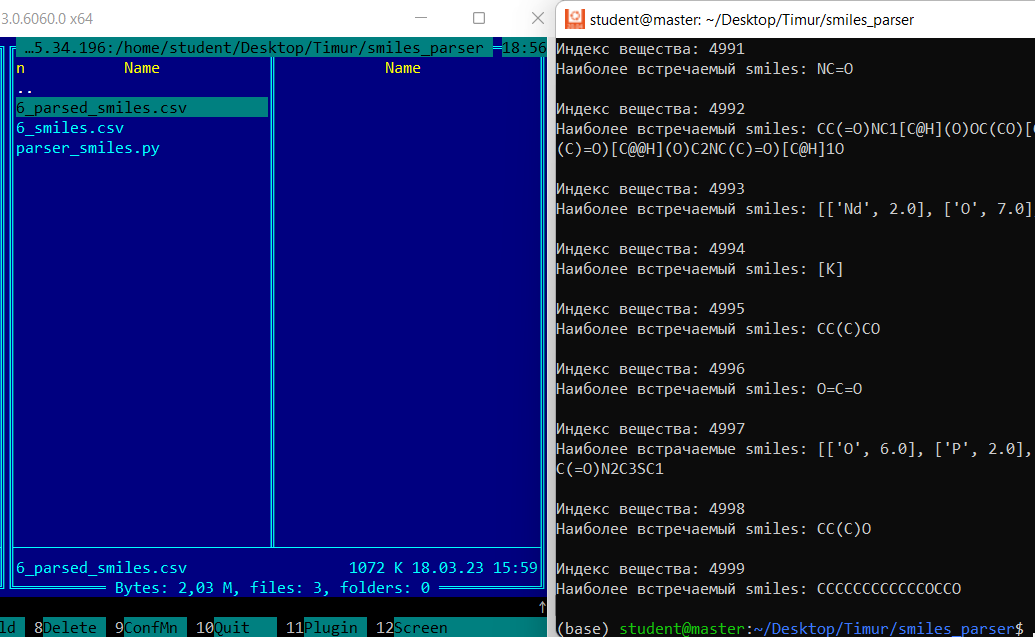

In [56]:
from IPython.display import Image

image_path = 'parser_smiles.png'
width = 700
Image(filename=image_path, width=width)

#### После парсинга осталось 337 пропусков в normalised_name

In [49]:
df_parsed = pd.read_csv('6_parsed_smiles.csv')
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4588 non-null   object 
 2   Journal                 4588 non-null   object 
 3   Title                   4588 non-null   object 
 4   Name                    5000 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  557 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         4663 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


#### Удалим строчки, у которых не нашлось смайлс

In [62]:
# Удалить строки с пустыми значениями в столбце 'normalised_name'
df_parsed = df_parsed.dropna(subset=['normalised_name'])

# Обновить индексы
df_parsed = df_parsed.reset_index(drop=True)

In [65]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4663 entries, 0 to 4662
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     4663 non-null   object 
 1   Date                    4265 non-null   object 
 2   Journal                 4265 non-null   object 
 3   Title                   4265 non-null   object 
 4   Name                    4663 non-null   object 
 5   measurement_error       4663 non-null   float64
 6   measurement_wavelength  511 non-null    object 
 7   measurement_method      4663 non-null   object 
 8   normalised_name         4663 non-null   object 
 9   raw_value               4663 non-null   object 
 10  specifier               4663 non-null   object 
dtypes: float64(1), object(10)
memory usage: 400.9+ KB


#### Узнаем количество ячеек, в которых по встречаемости несколько смайлс

In [66]:
# подсчет количества ячеек, содержащих слово "или" в колонке "normalised_name"
count = df_parsed[df_parsed['normalised_name'].str.contains('или', na=False)].shape[0]

print("Количество ячеек с 'или':", count)

Количество ячеек с 'или': 417


#### Их достаточно много, чтобы отбирать вручную, поэтому рандомно выберем одно из значений смайлс

In [67]:
import pandas as pd

# функция для замены ячейки со случайным смайлом из списка
def replace_smile(cell):
    smiles = cell.split(' или ')
    new_smile = random.choice(smiles)
    return new_smile

# ищем ячейки с "или" и заменяем их на случайный смайл из списка
df_str = df_parsed['normalised_name'].str.contains(' или ')
df_parsed.loc[df_str, 'normalised_name'] = df_parsed.loc[df_str, 'normalised_name'].apply(replace_smile)

In [71]:
# подсчет количества ячеек, содержащих слово "или" в колонке "normalised_name"
count = df_parsed[df_parsed['normalised_name'].str.contains('или', na=False)].shape[0]

print("Количество ячеек с 'или':", count)

Количество ячеек с 'или': 0


In [72]:
df_parsed.to_csv('6_good_smiles.csv', index=False)